In [1]:
import numpy as np
import pandas as pd
import json 
import seaborn as sns
import string
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from pingouin import multivariate_normality
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/charlesreinertson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/charlesreinertson/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Read in data

In [2]:
df = pd.read_csv('data/pre-processed.csv', index_col=None) 
df.head()

,title,cast,crew,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
0,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800
1,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500
2,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,6.3,4466
3,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,7.6,9106
4,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",6.1,2124


# Only perform analysis on english movies

In [3]:
df = df[df['original_language'] == 'en']

# General EDA

In [4]:
# get index, columns, non_null count, data type, memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4503 entries, 0 to 4798
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 4503 non-null   object 
 1   cast                  4503 non-null   object 
 2   crew                  4503 non-null   object 
 3   budget                4503 non-null   int64  
 4   genres                4503 non-null   object 
 5   id                    4503 non-null   int64  
 6   keywords              4503 non-null   object 
 7   original_language     4503 non-null   object 
 8   original_title        4503 non-null   object 
 9   overview              4503 non-null   object 
 10  popularity            4503 non-null   float64
 11  production_companies  4503 non-null   object 
 12  production_countries  4503 non-null   object 
 13  release_date          4503 non-null   object 
 14  revenue               4503 non-null   int64  
 15  runtime              

In [5]:
# change columns to correct data type
# change type of column
df["title"] = df["title"].astype("string")
df["original_language"] = df["original_language"].astype("string")
df["original_title"] = df["original_title"].astype("string")
df["overview"] = df["overview"].astype("string")
df["release_date"] = pd.to_datetime(df["release_date"])
df["status"] = df["status"].astype("string")
df["tagline"] = df["tagline"].astype("string")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4503 entries, 0 to 4798
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   title                 4503 non-null   string        
 1   cast                  4503 non-null   object        
 2   crew                  4503 non-null   object        
 3   budget                4503 non-null   int64         
 4   genres                4503 non-null   object        
 5   id                    4503 non-null   int64         
 6   keywords              4503 non-null   object        
 7   original_language     4503 non-null   string        
 8   original_title        4503 non-null   string        
 9   overview              4503 non-null   string        
 10  popularity            4503 non-null   float64       
 11  production_companies  4503 non-null   object        
 12  production_countries  4503 non-null   object        
 13  release_date      

In [7]:
df.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.503000e+03,4503.000000,4503.000000,4.503000e+03,4503.000000,4503.000000,4503.000000
mean,3.040786e+07,55627.086387,22.187274,8.651726e+07,106.495225,6.068377,719.343105
std,4.151041e+07,86808.746123,32.516649,1.669837e+08,22.341001,1.178534,1263.547850
min,0.000000e+00,5.000000,0.000372,0.000000e+00,0.000000,0.000000,0.000000
25%,1.000000e+06,9021.500000,5.010111,0.000000e+00,93.000000,5.600000,58.500000
50%,1.500000e+07,14435.000000,13.706357,2.204428e+07,103.000000,6.200000,252.000000
75%,4.000000e+07,57104.000000,29.255485,9.821056e+07,117.000000,6.800000,788.500000
max,3.800000e+08,447027.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


# Pre-Processing Steps of "Overview" Column

### Get a list of just the "overview" column

In [8]:
def to_list(df):
    
    return list(df['overview'])

### Make all terms lowercase
Return a numpy array

In [9]:
def lower_case(overview):
    
    return np.char.lower(overview)

### Remove stop words
The most commonly occurring words that don’t give any additional value to the document vector. 

In [10]:
def remove_stopwords(overview):

    overview = np.char.split(overview)

    cachedStopWords = stopwords.words("english")

    for i, value in enumerate(overview.tolist()):
        overview[i] = ' '.join([word for word in value if word not in cachedStopWords])  
    
    
    return list(overview)


### Remove punctuation
Except for the character "'" as we need that character when removing stopwords such as "hasn't"

In [11]:
def remove_punctuation(overview):
    stripPunct = str.maketrans('', '', ''.join(string.punctuation.split("'")))

    # works for 'any.string.inputted'
    return np.array([sentence.translate(stripPunct) for sentence in overview])

### Remove apostrophe

In [12]:
def remove_apostrophe(overview):
    stripPunct = str.maketrans('', '', "’‘''")

    return np.array([sentence.translate(stripPunct) for sentence in overview])


### Remove single characters
It is unlikely a single character will give us useful information

In [13]:
def remove_chars(overview):
    overview = np.char.split(overview)

    for i, value in enumerate(overview.tolist()):
        overview[i] = ' '.join([word for word in value if len(word) > 1])  
    
    
    return list(overview)

### Lemmatization
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meanings to one word.
<br><br>
-> rocks : rock <br>
-> corpora : corpus <br>
-> better : good 

In [14]:
def lemmatizer(overview):
    lemmatizer = WordNetLemmatizer()

    for i, value in enumerate(overview.tolist()):
        pos_tag(word_tokenize(value))
        lemma = []
        
        for word, tag in pos_tag(word_tokenize(value)):
            wntag = tag[0].lower()
            wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
            if not wntag:
                lemma.append(word)
            else:
                lemma.append(lemmatizer.lemmatize(word, wntag))
        
        overview[i] = ' '.join(lemma)
    
    return list(overview)

## Pre-Processing Order of Steps

In [15]:
# Get a list of just the "overview" column
overview = to_list(df)
print("-------Step 1: To list-------")
print(overview[2:3])
print('')

overview = lower_case(overview)
print("-------Step 2: Lower case-------")
print(overview[2:3])
print('')

overview = remove_punctuation(overview)
print("-------Step 3: Remove punctuation-------")
print(overview[2:3])
print('')

overview = remove_chars(overview)
print("-------Step 4: Remove single characters-------")
print(overview[2:3])
print('')

overview = remove_stopwords(overview)
print("-------Step 5: Remove stopwords-------")
print(overview[2:3])
print('')

# remove apostrophe after remove stopwords as "doesn't" is a stopword for example
overview = remove_apostrophe(overview)
print("-------Step 6: Remove apostrophe-------")
print(overview[2:3])
print('')

overview = lemmatizer(overview)
print("-------Step 7: Lemmatizing-------")
print(overview[2:3])
print('')

# after lemmtizer some single characters are created
overview = remove_chars(overview)
print("-------Step 8: Remove single characters, again-------")
print(overview[2:3])
print('')

-------Step 1: To list-------
['A cryptic message from Bond’s past sends him on a trail to uncover a sinister organization. While M battles political forces to keep the secret service alive, Bond peels back the layers of deceit to reveal the terrible truth behind SPECTRE.']

-------Step 2: Lower case-------
['a cryptic message from bond’s past sends him on a trail to uncover a sinister organization. while m battles political forces to keep the secret service alive, bond peels back the layers of deceit to reveal the terrible truth behind spectre.']

-------Step 3: Remove punctuation-------
['a cryptic message from bond’s past sends him on a trail to uncover a sinister organization while m battles political forces to keep the secret service alive bond peels back the layers of deceit to reveal the terrible truth behind spectre']

-------Step 4: Remove single characters-------
['cryptic message from bond’s past sends him on trail to uncover sinister organization while battles political for

# Get TF-IDF of Overview Column
TF = (Number of time the word occurs in the text) / (Total number of words in text) <br>
IDF = (Total number of documents / Number of documents with word t in it) <br>
TF-IDF = TF * IDF

### Convert a collection of text documents to a matrix of token counts.

In [16]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(overview)

In [17]:
vectorizer.get_feature_names_out()[1000:1020]

array(['angelina', 'angelov', 'angels', 'anger', 'angie', 'anglade',
       'angle', 'anglican', 'anglo', 'angloirish', 'anglomaratha',
       'angrily', 'angry', 'angst', 'angus', 'animal', 'animalsand',
       'animalwarriors', 'animate', 'animated'], dtype=object)

In [18]:
print(X.toarray().shape)

(4503, 18918)


### We transform a count matrix to a normalized TF-IDF representation to measure weights

In [19]:
transformer = TfidfTransformer()
transformed_weights = transformer.fit_transform(X)
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': vectorizer.get_feature_names_out(), 'weight': weights})

In [20]:
weight_dict = dict(value for value in zip(weights_df['term'], weights_df['weight']))

### Get the top 10 words based off of TF-IDF

In [21]:
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
9949,life,0.015623
6451,find,0.014790
11737,new,0.013121
18837,young,0.012580
12162,one,0.012341
18699,world,0.011675
10462,man,0.011403
7112,get,0.011267
16606,take,0.011110
17477,two,0.011003


# Determine if normalized combined TF-IDF of all words from the overview description has a correlation with popularity
sum(TF-IDF weights of words in each sentence of overview) / count(words in each sentence of overview)

### Create a new dataframe column "Combined TF-IDF"
This column is the sum of each words in the "Overviews" column's TF-IDF score

In [22]:
overview = np.char.split(list(overview))
tfidf_count = []

for i, sentence in enumerate(overview.tolist()):
    sum_weights = np.array([weight_dict[word] for word in sentence if word in weight_dict]).sum()
    sentence_length = len(sentence)
    if sentence_length != 0:
        tfidf_count.append(sum_weights / sentence_length)
    else:
        tfidf_count.append(0)

### Create a new dataframe of all relevant information for the final analysis

In [23]:
df = pd.DataFrame({'Popularity':list(df['popularity']),'Overview':overview, 'TF-IDF Total': tfidf_count})

In [24]:
df.head()

,Popularity,Overview,TF-IDF Total
0,150.437577,"[22nd, century, paraplegic, marine, dispatch, ...",0.002264
1,139.082615,"[captain, barbossa, long, believe, dead, come,...",0.003307
2,107.376788,"[cryptic, message, bond, past, sends, trail, u...",0.002211
3,112.312950,"[follow, death, district, attorney, harvey, de...",0.002100
4,43.926995,"[john, carter, warweary, former, military, cap...",0.002150


### Find if "Popularity" column correlates with "TF-IDF Total"
Understand the relationships between two variables at a time via a pairwise plot

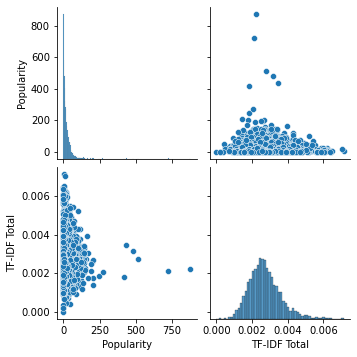

In [25]:
dfs = df[list(df._get_numeric_data().columns)]
sns.pairplot(dfs)  # pairwise plots - may take a long time to run
plt.show()

The Henze-Zirkler Multivariate Normality Test determines whether or not a group of variables follows a multivariate normal distribution. The null and alternative hypotheses for the test are as follows:

H0 (null): The variables follow a multivariate normal distribution.

Ha (alternative): The variables do not follow a multivariate normal distribution.

In [27]:
#perform the Henze-Zirkler Multivariate Normality Test
multivariate_normality(dfs, alpha=.05)

# This tells us that our results are not normal?

HZResults(hz=142.6213862561677, pval=8.851516602258907e-124, normal=False)

# Key findings:
The most popular movies have descriptions with combined TF-IDF scores from all words of the overview as close to the mean of TF-IDF combined word total as possible. What can the writers of movie descriptions learn from this? The most popular movies choose to use words on average that are not extremely common but also not extremely rare. It is best to play it safe while at the same time showing more creativity than your average 5th grader when writing movie reviews. Just be average.